<a href="https://colab.research.google.com/github/dotcsv/FastAI-Deep-Learning-for-Coders/blob/master/Notes%20Lecture%201%20-%20(Espa%C3%B1ol).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lección 1 - Clasificación de imágenes

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   609  100   609    0     0   3980      0 --:--:-- --:--:-- --:--:--  3980
Updating fastai...
Done.


Importamos la librería de **fastai V1**, construida por la buena gente de Fast.AI como una extensión de **Pytorch 1.0**, añadiendo más funcionalidades de Deep Learning y mejor optimizadas. 

Como somos Data Scientists y el output que buscamos es más la información extraída de los datos que la propia eficiencia del código implementado, nos podemos permitir hacer cosas como importarnos todos los módulos de la librería usando el ` import *`. 

***La vida del DS, la vida mejor!***

In [0]:
from fastai import *
from fastai.vision import *

## A. Echando un vistazo a los datos

Durante el curso se trabajará con datasets académicos y datasets reales sacados de ***Kaggle***. La ventaja de los datasets académicos es que asociados a ellos existen muchos papers que documentan cuál es el rendimiento para los diferentes modelos existentes aplicados a estos datos.

En este caso, empezamos con el dataset ***Oxford-IIIT Pet Dataset*** que contiene 37 clases diferentes de perros y gatos: 12 razas de gatos y 25 razas de perros. Este problema de clasificación donde las clases incluyen diferentes categorías de una misma clase (ej. diferentes razas de un determinado animal) se denomina **fine-grained classification.**

El paper de 2012 asociado a este dataset reporta un rendimiento del 59.21% en las predicciones. Este problema que hace unos años era extremadamente dificil de solucionar, ahora es bastante sencillo de resolver haciendo uso de modelos de Deep Learning.

In [0]:
# Podemos usar help para ver la documentación de la función.
help(untar_data)

# Igualmente podemos usar ? para abrir una ventana emergente con la misma info.
untar_data?

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [0]:
# FastAI provee un listado de URLs interesantes a datasets de pruebas en 'URLs'
for key, url in URLs.__dict__.items():
  print(key,':', url)

__module__ : fastai.datasets
__doc__ : Global constants for dataset and model URLs.
LOCAL_PATH : /content
S3 : https://s3.amazonaws.com/fast-ai-
S3_IMAGE : https://s3.amazonaws.com/fast-ai-imageclas/
S3_IMAGELOC : https://s3.amazonaws.com/fast-ai-imagelocal/
S3_NLP : https://s3.amazonaws.com/fast-ai-nlp/
S3_COCO : https://s3.amazonaws.com/fast-ai-coco/
S3_MODEL : https://s3.amazonaws.com/fast-ai-modelzoo/
COCO_SAMPLE : https://s3.amazonaws.com/fast-ai-coco/coco_sample
COCO_TINY : http://files.fast.ai/data/examples/coco_tiny
MNIST_SAMPLE : http://files.fast.ai/data/examples/mnist_sample
MNIST_TINY : http://files.fast.ai/data/examples/mnist_tiny
IMDB : https://s3.amazonaws.com/fast-ai-nlp/imdb
IMDB_SAMPLE : http://files.fast.ai/data/examples/imdb_sample
HUMAN_NUMBERS : http://files.fast.ai/data/examples/human_numbers
ADULT_SAMPLE : http://files.fast.ai/data/examples/adult_sample
ML_SAMPLE : http://files.fast.ai/data/examples/movie_lens_sample
PLANET_SAMPLE : http://files.fast.ai/data/exa

In [0]:
# Descarga el dataset a partir de su url, y devuelve un objeto tipo path.
path = untar_data(URLs.PETS) ; path

PosixPath('/content/data/oxford-iiit-pet')

Hacer uso de los **PosixPath objects** es mucho más conveniente que utilizar las string tradicionales  para expresar las path a directorios, por todas las funcionalidades que añade.

In [0]:
path.ls()

[PosixPath('/content/data/oxford-iiit-pet/images'),
 PosixPath('/content/data/oxford-iiit-pet/annotations')]

In [0]:
path_img = path / 'images'
path_ann = path / 'annotations'

path_img.ls()[:10]

[PosixPath('/content/data/oxford-iiit-pet/images/Ragdoll_80.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/Persian_264.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/Sphynx_77.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/scottish_terrier_63.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/shiba_inu_72.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/saint_bernard_191.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/shiba_inu_140.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/Persian_99.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/great_pyrenees_143.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/Maine_Coon_217.jpg')]

En este caso, el dataset que estamos utilizando no aporta un archivo con las etiquetas de las imágenes, sino que estas están incluidas dentro del nombre de los archivos porque... bueno, porque para qué molestarte en dejarlo fácil una vez te has currado un dataset ¿verdad?. 

In [0]:
 # Fijamos un seed para las pruebas.
np.random.seed(2)

# Sacamos el listado con todos los nombres de archivo.
fnames = get_image_files(path_img)

# Definimos un patrón regex para extraer los nombres de las imágenes.
pat = r'/([^/]+)_\d+.jpg$'


# Usamos esta función de la librería para cargar imágenes desde el path

# ¿Qué hace ImageDataBunch?   : Genera el dataset a partir de un conjunto de imágenes.
# ¿Qué hace el parámetro pat? : Ejecuta la operación regex para extraer las etiquetas del nombre del archivo.
# ¿Qué es ds_tfms?            : Tito Jeremy luego nos cuenta.
# ¿Por qué el size de 224?    : Necesitamos que todas las imágenes tenga el mismo tamaño por limitaciones de GPU. (Cuadradas)
#                             : En la siguiente parte del curso nos dirá cómo trabajar con rectangulares, que dan mejor rendimiento.
#                             : y el 224 nos lo cuenta luego...

data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)

Aquí podemos ver que el tipo de objeto que nos devuelve es del tipo **DataBunch**, donde los datos ya se estructuran sólos en *train* y *validation*, y cada uno con sus matrices de entrada y salida *X* e *Y*. Todo muy cómodo y para toda la familia.

In [0]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category Ragdoll, Category Persian, Category Sphynx, Category saint_bernard, Category shiba_inu]...
Path: /content/data/oxford-iiit-pet/images
x: ImageItemList (5912 items)
[Image (3, 500, 375), Image (3, 307, 396), Image (3, 287, 500), Image (3, 375, 500), Image (3, 395, 500)]...
Path: /content/data/oxford-iiit-pet/images;

Valid: LabelList
y: CategoryList (1478 items)
[Category leonberger, Category Egyptian_Mau, Category basset_hound, Category Bombay, Category beagle]...
Path: /content/data/oxford-iiit-pet/images
x: ImageItemList (1478 items)
[Image (3, 427, 500), Image (3, 360, 480), Image (3, 500, 332), Image (3, 333, 500), Image (3, 318, 500)]...
Path: /content/data/oxford-iiit-pet/images;

Test: None

Una de las cosas que hay que encargarse es de normalizar los datos (es decir, centrar la media a 0 y la desviación típica a 1) de cada una de las distribuciones de los canales de color de las intensidades de los píxeles de cada imagen (...coge aire!). Ésto lo hacemos para facilitar el entrenamiento de tu modelo, ya que tener variables con escalas muy diferentes hace que el proceso de optimización sea más ineficiente.

En este caso usamos una función de la própia librería para hacer dicha normalización. De momento no se especifica el sentido de usar `imagenet_stats` aunque se intuye que está utilizando las estadísticas del dataset ImageNet, que al final expresan de manera más general cuales son los parámetros de las distribuciones de los canales de color para un gran conjunto de imágenes. Aún así, tito Jeremy nos contará más después.

In [0]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [0]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category Ragdoll, Category Persian, Category Sphynx, Category saint_bernard, Category shiba_inu]...
Path: /content/data/oxford-iiit-pet/images
x: ImageItemList (5912 items)
[Image (3, 500, 375), Image (3, 307, 396), Image (3, 287, 500), Image (3, 375, 500), Image (3, 395, 500)]...
Path: /content/data/oxford-iiit-pet/images;

Valid: LabelList
y: CategoryList (1478 items)
[Category leonberger, Category Egyptian_Mau, Category basset_hound, Category Bombay, Category beagle]...
Path: /content/data/oxford-iiit-pet/images
x: ImageItemList (1478 items)
[Image (3, 427, 500), Image (3, 360, 480), Image (3, 500, 332), Image (3, 333, 500), Image (3, 318, 500)]...
Path: /content/data/oxford-iiit-pet/images;

Test: None

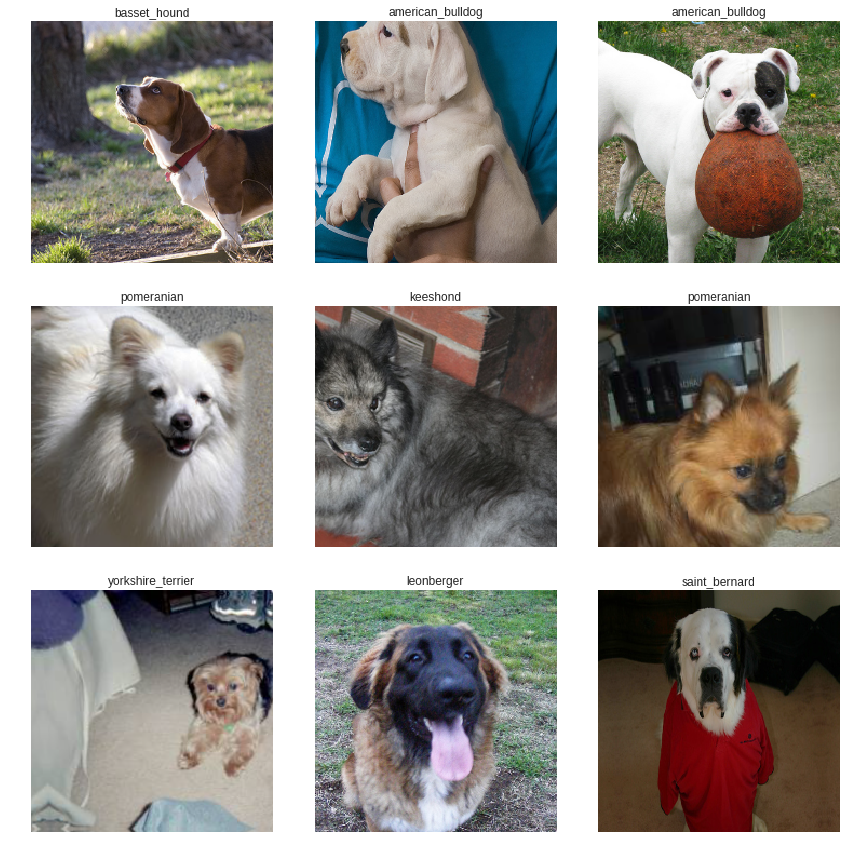

In [0]:
# Podemos echar un vistazo a las imágenes de nuestro dataset.
data.show_batch(rows=3)

In [0]:
# Y también a las clases a predecir...
data.classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

A continuación podemos crear nuestro modelo para resolver la tarea. En este caso va a utilizar la arquitectura ResNet34, un tipo especial de red neuronal convolucional (más detalles en próximas lecciones). **OJO!** Aunque en el vídeo del curso se muestre que se usa la función ConvLearner, este es el nombre que tenía la función en una versión previa. Actualmente esta función usa el nombre de `create_cnn(...)`. Es bueno acceder a la versión de los notebooks publicadas en el repositorio oficial. 

* Link al repositorio del curso : https://github.com/fastai/course-v3/tree/master/nbs/dl1

Cuando llamamos a la función `create_cnn` la función automáticamente descargará los pesos del modello ResNet34 pre-entrenado sobre el dataset ImageNet de +1.500.000 imágenes. Con esto lo que hacemos es aprovecharnos del conocimiento de un modelo ya entrenado para resolver una tarea parecida, y usarlo como punto de partida para alcanzar un buen rendimiento en menor tiempo y con un menor volumen de datos. Es decir, nos estamos beneficiando de la **transferencia de conocimiento** (*transfer learning*) del modelo.

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 91912003.68it/s]


(continuará...)

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.400730,0.339151,0.099459
2,0.558280,0.283594,0.092693
3,0.341332,0.244397,0.080514
4,0.250385,0.237397,0.079838
